
## Project: **Finding Lane Lines on the Road** 
***
I used number of tools and technique to identify Lane Lines on the Road. The goal is to indentify extrapolated line lane on test images and finally apply to video stream. I used Python, OpenCV, and Jupyter notebook in this project.

The following methods are use : apply color selection/filtering, grayscale, gaussian smoothing, canny edge detection, region of interest selection, Hough transform line letection, combine images with slope detection left-right lines and draw them for display. 

Once tested with images, I use methods on video stream.

Below is sample expected output images :



<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Image with line segments </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Expected image output with connecting line segments.</p> 
 </figcaption>
</figure>

## Import Packages

In [125]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


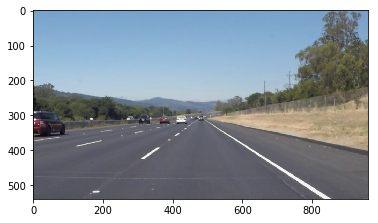

In [126]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [127]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

            

def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    

    right_lines_x = []
    right_lines_y = []
    left_lines_x = []
    left_lines_y = []
    
    for line in lines:
        #initialize first line
        x1, y1, x2, y2 = line[0] 
        
        # Calculate slope
        slope = (y2 - y1) / (x2 - x1)
            
        # Filter lines based on slope and determine as positive slope or negative slope
        # Check for positive slope as right line and negative as left line. Also verify distance from center image 
        # Only slope between 0.5 to 0.8 are accepted
        
        if  slope < 0.8 and slope > 0 and x1 > (img.shape[1] / 2) and x2 > (img.shape[1] / 2) and abs(slope) > 0.5:
            right_lines_x.append(x1)
            right_lines_x.append(x2)
            right_lines_y.append(y1)
            right_lines_y.append(y2)
        elif slope > -0.8 and slope < 0 and x1 < (img.shape[1] / 2) and x2 < (img.shape[1] / 2) and abs(slope) > 0.5:
            left_lines_x.append(x1)
            left_lines_x.append(x2)
            left_lines_y.append(y1)
            left_lines_y.append(y2)
    
    # set initial value in case of error
    left_slope=1
    left_intercept=1
    right_slope=1
    right_intercept=1
    right_drawline = False
    left_drawline = False
    
    
    # Y point of polygon bottom and top
    
    point_y1 = img.shape[0]
    point_y2 = img.shape[0] * 0.62 # Set height of polygon
    
    if len(right_lines_x) > 0:
        right_slope, right_intercept = np.polyfit(right_lines_x, right_lines_y, 1)      
        right_drawline = True
    
    # x-right point of polygon
    
    point_right_x1 = (point_y1 - right_intercept) / right_slope
    point_right_x2 = (point_y2 - right_intercept) / right_slope
    
    if len(left_lines_x) > 0:
        left_slope, left_intercept = np.polyfit(left_lines_x, left_lines_y, 1) 
        left_drawline = True
    
    # x-left point of polygon.
    
    point_left_x1 = (point_y1 - left_intercept) / left_slope
    point_left_x2 = (point_y2 - left_intercept) / left_slope
    
    # Draw the right and left lines on image, casting all input to integer.
    
    if right_drawline:
        cv2.line(img, (int(point_right_x1), int(point_y1)), (int(point_right_x2), int(point_y2)), color, thickness)
    if left_drawline:
        cv2.line(img, (int(point_left_x1), int(point_y1)), (int(point_left_x2), int(point_y2)), color, thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [128]:
import os
os.listdir("test_images/")

['solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteCurve.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowLeft.jpg']

In [129]:
def render_image(image_in):
    
    # Filter out color except yellow and white to supress unwanted line
    # Apply mask to White color
    set_lo_white = np.array([100, 200, 200])
    set_hi_white = np.array([255, 255, 255])
    set_white_mask = cv2.inRange(image_in, set_lo_white, set_hi_white)
    
    # Apply white bitwise on image 
    white_image_out = cv2.bitwise_and(image_in, image_in, mask=set_white_mask)
    
    # Apply mask to Yellow color
    set_lo_yellow = np.array([99,100,100])
    set_hi_yellow = np.array([255,255,255])
    hue_sv = cv2.cvtColor(image_in, cv2.COLOR_BGR2HSV)
    set_yellow_mask = cv2.inRange(hue_sv, set_lo_yellow, set_hi_yellow)
    
    # Apply white bitwise on image 
    yellow_image_out = cv2.bitwise_and(image_in, image_in, mask=set_yellow_mask)
    
    # Apply grayscale the combined filtered image
    gray = grayscale(cv2.addWeighted(white_image_out, 1., yellow_image_out, 1., 0.))
    
        
    # Gauss kernel parameter
    gauss_kernel_size = 5

    # Apply Gaussian smoothing
    blur_gray = gaussian_blur(gray, gauss_kernel_size)
    
    # Canny Edge Detector parameter
    canny_low_threshold = 50
    canny_high_threshold = 150
      
    # Apply Canny Edge Detector
    edges = canny(blur_gray, canny_low_threshold, canny_high_threshold)
    
    # Apply region-of-interest on Canny edge
    imageshape = image_in.shape
    
    # find vertices
    vertices = np.array([[\
        (0.15*imageshape[1] // 2, imageshape[0]),\
        (0.93*imageshape[1] // 2, imageshape[0] - 0.395*imageshape[0]),\
        (imageshape[1] - 0.93*imageshape[1] // 2, imageshape[0] - 0.395*imageshape[0]),\
        (imageshape[1] - 0.15*imageshape[1] // 2, imageshape[0])]]\
        , dtype=np.int32)
    

    masked_edges = region_of_interest(edges, vertices)
    
    
    # Hough Transform Parameter
    hough_rho =1 # distance resolution in pixels of the Hough grid
    hough_theta = 1 * np.pi/180 # angular resolution in radians of the Hough grid
    hough_threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    hough_min_line_length = 15 #minimum number of pixels making up a line
    hough_max_line_gap = 50    # maximum gap in pixels between connectable line segments

    # Apply Hough line detection
    line_image = hough_lines(masked_edges, hough_rho, hough_theta, hough_threshold, hough_min_line_length, hough_max_line_gap)

    
    return weighted_img(line_image, image_in)
    ##return line_image

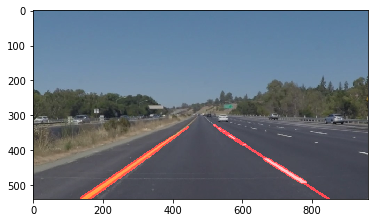

In [130]:
#process on all test images and save on test_images_output directory
       
imageList = os.listdir("test_images/")
for image in imageList:
    render = render_image(mpimg.imread("test_images/" + image))
    #print (image)
    plt.imshow(render)
    plt.savefig( "test_images_output/" + image )
    

## Test on Videos

We can test our solution on two provided videos:

`solidWhiteRight.mp4`
`solidYellowLeft.mp4`
`challenge.mp4`



In [131]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [132]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes

    return render_image(image)

### Test on Solid White Right VIdeo

In [133]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:08<00:00, 25.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 6.07 s, sys: 804 ms, total: 6.87 s
Wall time: 9.87 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [134]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

### Test on Solid Yellow Video

In [135]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:28<00:00, 23.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 19.5 s, sys: 2.37 s, total: 21.8 s
Wall time: 29.9 s


In [136]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

### Test on Challenge Video

In [137]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:19<00:00, 12.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 12.6 s, sys: 2.33 s, total: 14.9 s
Wall time: 21.4 s


In [138]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))


## Reflection

Line successfully combined on video stream. However, numbers of flaw still occur specifically on challenge.mp4 video. Annotated version of video and images can be found on "test_video_output" and "test_images_output" folders.

### Pipeline consists of steps:

* Apply a color mask to suppress unwanted portion of images/videos
* Apply grayscale
* Performing edge detection
* Selecting regions to search for lane lines boundary
* Extrapolate line segments
* Apply Hough transform and draw line segments


### Potential shortcomings of pipeline

The challenge video show couples flaws on methods as follow:
* Highly sensitive to color change of environment
* Requires some hard coded variables
* Quality of result dependend on lane location on images

### Possible improvements

* Need more videos to train and improve pipeline
* Better methodology to determine sensitive variable on pipeline and adjust automatically
* Automatically calculate region of interest and color mask range

